__________________________________________________________________________________________________________________________________________________
Author: Leila Fabiola Ferreira - 2022

# About the data
### The seed of Network - β-Catenin

β-Catenin is a multifunctional protein that plays an important role in the transduction of Wnt signals and in the intercellular adhesion by linking the cytoplasmic domain of cadherin.(From: Handbook of Immunohistochemistry and in Situ Hybridization of Human Carcinomas, 2006)

It is a cell adhesion molecule and transcriptional regulator implicated in cancer (Çelen İ, Ross KE, Arighi CN, Wu CH, 2015).

![image](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/2bct_murinebcat.jpg/375px-2bct_murinebcat.jpg)

Bibliography: 

Çelen İ, Ross KE, Arighi CN, Wu CH (2015): Bioinformatics Knowledge Map for Analysis of Beta-Catenin Function in Cancer. PLoS ONE 10(10): e0141773. https://doi.org/10.1371/journal.pone.0141773). 

The biological analysis of the network can be founded in this paper: 
(https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0141773).

The dataset used in this notebook can be founded in:
(https://journals.plos.org/plosone/article/file?type=supplementary&id=10.1371/journal.pone.0141773.s001)
__________________________________________________________________________________________________________________________________________________

# Network Analysis and Link Prediction

## Network Science
### APS

#### First we got the network features

• e.g. Nodes and edges quantity, Graph Density, Average Clustering, Node Conectivity;

• Nodes measures;
![image](dataframe_measures.JPG)

• Paths and diameter;

• Communities.

#### Link prediction strategy:

![image](https://user-images.githubusercontent.com/88637523/167493735-db9c5099-94c3-406e-a6a8-8496a67963d3.png)

• Obtain a sample of existing links (edges);

• Obtain the same size sample of non-existent links (non_edges);

• Obtain the Jaccard Coefficient of the samples;

• Obtain the Preferential Attachment of the samples;

• Obtain the Resource Allocation Index of the samples;

• Obtain the Katz Matrix and Katz Scores of the samples (Reference: https://github.com/alphaWizard/link-prediction/blob/master/similarities.py);

• Obtain the Rooted Page Rank of the samples (Reference: https://github.com/alphaWizard/link-prediction/blob/master/similarities.py).

 After completing these steps, a dataframe was created with all the data obtained in the previous item to be used as a training set for the classification models. The parameters obtained are part of a set of functions for predicting links in the Networkx library and some functions of alphaWizard on Github (https://github.com/alphaWizard/link-prediction). Each index by itself can be used for link prediction in case of Networkx parameters (Jaccard Coefficient, Preferential Attachment and Resource Allocation Index), so the main idea is to combine these values in links labeled as non_edge = 0 and edge = 1 with balanced samples to evaluate the joint performance in a classification model.
Before training the models, the data were standardized using Sklearn's StandarScaler() method, since the data obtained were at different scales, as can be seen in the following figure:

![image](dataframe.JPG)
 

 It is an important step because the models perform better with data in a standardized range, avoiding giving greater weight to data with larger scales. Standardization scales the data by subtracting the mean and dividing by the standard deviation, which results in a distribution with a standard deviation and a variance of 1.
Finally, five different models were trained and tested to classify links as edge (1) or non-edge (0).

#### The metrics analyzed were confusion matrix, accuracy and F1 score.

__________________________________________________________________________________________________________________________________________________

Importing the libraries

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from similarities import *

import warnings
warnings.filterwarnings('ignore')

A function to plot confusion-matrix

In [2]:
def plot_confusion_matrix(y,y_predict):

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); 
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['not edge', 'edge']); 
    ax.yaxis.set_ticklabels(['not edge', 'edge'])

Generating the graph from a dataframe

In [2]:
# reading the dataset
df = pd.read_excel('protein.xlsx')

# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Protein 1        861 non-null    object
 1   Protein 2        861 non-null    object
 2   Relation Type    861 non-null    object
 3   Evidence Source  861 non-null    object
 4   Color            861 non-null    object
dtypes: object(5)
memory usage: 33.8+ KB


In [5]:
# sample
df.head()

,Protein 1,Protein 2,Relation Type,Evidence Source,Color
0,KAT2B,CTNNB1,acetylation,PhosphoSitePlus,orange
1,EP300,CTNNB1,acetylation,PhosphoSitePlus,orange
2,NFKB1,CTNNB1,coactivation,TcoF,green
3,ESR1,CTNNB1,coactivation,TcoF,green
4,TCF7L2,CTNNB1,coactivation,TcoF,green


In [3]:
# generating the graph from dataset
G = nx.from_pandas_edgelist(df,source='Protein 1',target='Protein 2',edge_attr=['Relation Type','Color'])

__________________________________________________________________________________________________________________________________________________

# Exploratory Analysis

Selecting information from the graph that will be used in the analysis

In [6]:
color = nx.get_edge_attributes(G,'Color').values()
nodes = list(G.nodes)
null_edges = list(nx.non_edges(G))
edges = list(nx.edges(G))
m = len(edges)
null_edges_sample = random.sample(null_edges, m) #select a sample of disconnected links of the same size as existing links  

Network overview

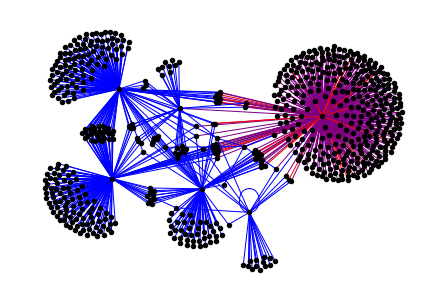

In [7]:
#plotting the graph
pos = nx.spring_layout(G)

options = {"node_size": 20,
           "node_color": "black",
           "linewidths": 1,
           "width": 1,
           }

nx.draw(G, pos, **options, edge_color=color)
plt.show()

________________________________________________________________________________________________________________
### Network information

Number of nodes and edges

Graph Density

Average clustering

Node connectivity (minimum number of nodes that must be removed to disconnect the graph)

Checking if the graph is directed or undirected

In [4]:
print('Nodes and Edges: ', nx.info(G))
print('Graph Density', nx.density(G))
print('Average Clustering', nx.average_clustering(G))
print('Node Conectivity', nx.node_connectivity(G)) 
print('Is the graph directed?' , nx.is_directed(G))

Nodes and Edges:  Graph with 702 nodes and 835 edges
Graph Density 0.003393605390752324
Average Clustering 0.0646614356678921
Node Conectivity 1
Is the graph directed? False


Checking the average degree of the graph

In [5]:
nodes,links = G.order(), G.size()
avg_deg = float(links)/nodes
print("Average Degree: ", avg_deg)
#calculando a média de grau do grafo

Average Degree:  1.1894586894586894


Getting the degrees of each node - Indicates the number of nodes adjacent to each node

In [10]:
degree = list(nx.degree(G))
def sort_key(degree):
    return degree[1]

def Convert(tup, di):
    di = dict(tup)
    return di

degrees = {}
degrees = Convert(degree, degrees)

degree.sort(key=sort_key, reverse=True)
for i in range(0,6):
    print(degree[i])

('CTNNB1', 392)
('NFKB1', 156)
('CEBPA', 150)
('ESR1', 83)
('AR', 31)
('LEF-1', 26)


Degree Centrality

This measure corresponds to the number of neighbors of each node divided by the maximum number of neighbors it could have.

The degree_centrality(G) function returns a dictionary where the keys are the nodes and the values are the degree centrality scores.

In [11]:
from operator import itemgetter
degcent = nx.degree_centrality(G)
degcents = sorted(degcent.items(), key=itemgetter(1), reverse=True)
for i in range(1,6):
    print(degcents[i])

('NFKB1', 0.2225392296718973)
('CEBPA', 0.21398002853067047)
('ESR1', 0.11840228245363767)
('AR', 0.0442225392296719)
('LEF-1', 0.037089871611982884)


Betweenness Centrality

This measure corresponds to the sum of the fraction of the shortest paths of all pairs that pass through the node.

Like the previous step, the betweenness_centrality(G) function returns a dictionary where the keys are the nodes and the values are the betweenness centrality scores.

In [12]:
betcent = nx.betweenness_centrality(G)
betcents = sorted(betcent.items(), key=itemgetter(1), reverse=True)
for i in range(1,6):
    print(betcents[i])

('NFKB1', 0.2998635792689058)
('CEBPA', 0.2852345569722979)
('ESR1', 0.13419429299908586)
('AR', 0.04425431527175711)
('LEF-1', 0.03991559986373399)


Closeness Centrality

This measure is the reciprocal of the sum of the shortest path distances from a node to all n-1 other nodes.
As the sum of the distances depends on the number of nodes in the graph, the proximity is normalized by the sum of the minimum possible distances n-1.
Therefore, the more central the node, the smaller the distance from its total to all other nodes.
The proximity measure can be related to the speed to spread information from one node to the other nodes in a sequential way.

Again, a data dictionary is obtained where the keys are the nodes and the values are the proximity centrality scores.

In [13]:
closecent = nx.closeness_centrality(G)
closecents = sorted(closecent.items(), key=itemgetter(1), reverse=True)
for i in range(1,6):
    print(closecents[i])

('NFKB1', 0.5007142857142857)
('CCND1', 0.49857752489331436)
('IL8', 0.4936619718309859)
('CEBPA', 0.4912403644008409)
('GDNF', 0.4775204359673024)


Eigenvector Centrality

Eigenvector centrality calculates the centrality of a node based on the centrality of its neighbors. For this, scores are assigned relative to all nodes in the network based on the concept that connections with high-scoring nodes will contribute more to the node's score.

Using the eigenvector_centrality(G) function, we also obtain a data dictionary where the keys are the nodes and the values are the eigenvector centrality scores.

In [14]:
eigencent = nx.eigenvector_centrality(G)
eigencents = sorted(eigencent.items(), key=itemgetter(1), reverse=True)
for i in range(1,6):
    print(eigencents[i])

('NFKB1', 0.11686727769465342)
('CEBPA', 0.10642769662597297)
('ESR1', 0.08941797583437162)
('AR', 0.054350598822919385)
('LEF-1', 0.051865681166959034)


In [15]:
cent_measures = {
    'degrees':degrees,
    'degreecent': degcent,
    'betweenness': betcent,
    'closeness' : closecent,
    'eigenvector': eigencent,
}
cent_measures = pd.DataFrame(cent_measures)
cent_measures.head()
#gerando um dataframe com todas as medidas de centralidade de cada nó

,degrees,degreecent,betweenness,closeness,eigenvector
KAT2B,2,0.002853,0.000000,0.425622,0.038163
CTNNB1,392,0.559201,0.783488,0.692688,0.698179
EP300,1,0.001427,0.000000,0.409463,0.033830
NFKB1,156,0.222539,0.299864,0.500714,0.116867
ESR1,83,0.118402,0.134194,0.447637,0.089418


In [16]:
corr_node = cent_measures.corr()
corr_node.style.background_gradient(cmap='coolwarm')

,degrees,degreecent,betweenness,closeness,eigenvector
degrees,1.000000,1.000000,0.998980,0.316962,0.832433
degreecent,1.000000,1.000000,0.998980,0.316962,0.832433
betweenness,0.998980,0.998980,1.000000,0.311283,0.837318
closeness,0.316962,0.316962,0.311283,1.000000,0.702858
eigenvector,0.832433,0.832433,0.837318,0.702858,1.000000


Paths

It is also possible to identify:

paths - The size is defined by the number of edges.

simple paths - a path where the nodes are not repeated.

shortest path - path between two nodes with the least number of edges.

The diameter of the graph, on the other hand, refers to the size of the shortest path between any two nodes in the graph.

In [17]:
nx.has_path(G, 'CTNNB1', 'AR')
#se resultar em True, significa que existe algum caminho entre os nós analisados

True

In [18]:
nx.shortest_path(G, 'CTNNB1', 'AR')
#localizando o caminho mais curto entre dois nós

['CTNNB1', 'AR']

Checking the diameter of the graph - Shortest path considering the longest path between nodes

In [19]:
nx.diameter(G)

4

Connected Components

For undirected graphs, a component is a maximally connected subgraph, which means that there is at least one path between any two nodes in that subgraph.

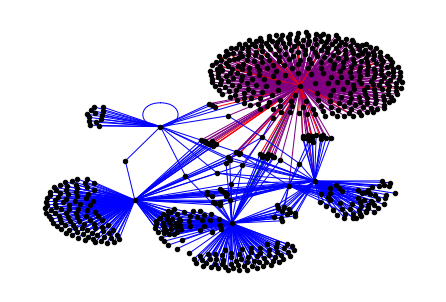

In [20]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
Giant = G.subgraph(Gcc[0])
pos = nx.spring_layout(Giant)

options = {"node_size": 20,
           "node_color": "black",
           "linewidths": 1,
           "width": 1,
           }

nx.draw(Giant, pos, **options, edge_color=color)
plt.show()

# Communities

Clicks

A complete graph has density 1, that is, all possible edges are present.
A click is an induced subgraph, formed by a subset of nodes, if and only if this subgraph is complete, so each pair of nodes is connected by an edge in a click.
The click size (number of nodes) can be pre-defined, the dyads being considered not very interesting.

Clique Density 1.1666666666666667


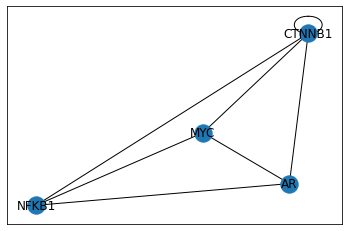

In [21]:
cliques = list(nx.find_cliques(G))
clique = [clique for clique in cliques if len(clique) > 3]
dens = G.subgraph(clique[0])
print('Clique Density', nx.density(dens))
nx.draw_networkx(dens, pos=pos, with_labels=True)

k-core

A k-core is a maximum subgraph that contains nodes of degree k or greater.
Thus, one can obtain a subgraph that forms a k-core using the function nx.k_core(G,k)

4


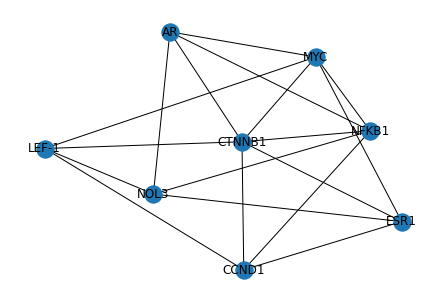

In [22]:
core = G.remove_edges_from(nx.selfloop_edges(G))
core = nx.k_core(G, 4)
print(nx.node_connectivity(core))
#obtendo a conectividade de nó do k-core
nx.draw(core, with_labels=True)
#obtendo um subgrafo com k-core igual a 4

### Community detection with Louvain

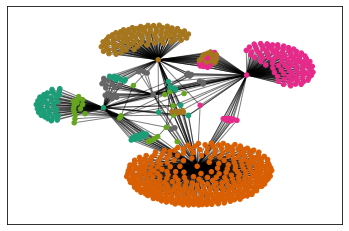

In [23]:
partition = community_louvain.best_partition(G)

pos = nx.spring_layout(G)

cmap = cm.get_cmap('Dark2', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=20, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.show()

________________________________________________________________________________________________________________

### Link Prediction using supervised learning classification algorithms, based on: Jaccard Coefficient,
### Resource Allocation Index, Preferential Attachment, Katz Scores and Rooted Page Rank 
________________________________________________________________________________________________________________

Defining edged and non-edged point sets with equal sizes for better data balancing

In [7]:
train_edges = edges
train_edges_false = null_edges_sample
print(len(train_edges), len(train_edges_false))

835 835


Jaccard Coefficient

In [8]:
pred_jc_true = nx.jaccard_coefficient(G, train_edges)
pred_jc_false = nx.jaccard_coefficient(G, train_edges_false)

In [9]:
jc_true = []
jc_false = []
jc_scores = []
node1 = []
node2 = []

for u, v, p in pred_jc_true:
    node1.append(u)
    node2.append(v)
    jc_true.append(p)
for u, v, p in pred_jc_false:
    node1.append(u)
    node2.append(v)
    jc_false.append(p)

jc_scores = jc_true + jc_false

df_dict = {}
df_dict['Node1'] = node1
df_dict['Node2'] = node2
df_dict['JC_score'] = jc_scores

Preferential Attachment

In [10]:
pred_pa_true = nx.preferential_attachment(G, train_edges)
pred_pa_false = nx.preferential_attachment(G, train_edges_false)

In [11]:
pa_true = []
pa_false = []
pa_scores = []

pa_scores = [s for (u,v,s) in pred_pa_true] + [s for (u,v,s) in pred_pa_false]
   
df_dict['PA_score'] = pa_scores 

Resource Allocation

In [12]:
pred_ra_true = nx.resource_allocation_index(G, train_edges)
pred_ra_false = nx.resource_allocation_index(G, train_edges_false)

In [13]:
ra_true = []
ra_false = []
ra_scores = []

ra_scores = [s for (u,v,s) in pred_ra_true] + [s for (u,v,s) in pred_ra_false]

df_dict['RA_score'] = ra_scores

Rooted Page Rank - Reference: https://github.com/alphaWizard/link-prediction/blob/master/similarities.py

In [14]:
rp_matrix = rpr_matrix(G)

In [15]:
def RP_compute(u,v):
    u = nodes.index(u)
    v = nodes.index(v)
    return rp_matrix[u,v] + rp_matrix[v,u]
    
rp_scores = [ RP_compute(u, v) for (u,v) in train_edges ] + [ RP_compute(u,v) for (u,v) in train_edges_false ]
df_dict['RP_score'] = rp_scores

Katz Scores - Reference: https://github.com/alphaWizard/link-prediction/blob/master/similarities.py

In [16]:
katz_matrix = katz_score(G)

In [17]:
katz_scores = [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges ] + [ katz_matrix[nodes.index(u), nodes.index(v)] for (u,v) in train_edges_false ]
df_dict['KATZ_score'] = katz_scores

Setting existing edges to 1 and non-existent edges to 0

In [18]:
is_edge = [ 1 ] * len(train_edges) + [ 0 ] * len(train_edges_false)
df_dict['is_edge'] = is_edge

Creating dataframe with the independent variables and dependent variable respectively, obtained previously

In [19]:
df = pd.DataFrame(df_dict)
df = df.sample(frac=1).reset_index(drop=True)

In [20]:
df.head()

,Node1,Node2,JC_score,PA_score,RA_score,RP_score,KATZ_score,is_edge
0,IGF2BP1,KRT1,1.0,1,0.002551,9.993896e-05,1.616567e-05,0
1,IGF1R,C3,0.0,1,0.000000,3.952658e-07,6.945497e-08,0
2,CTNNB1,FGF4,0.0,392,0.000000,1.305869e-01,4.041416e-03,1
3,IFRD1,OGN,0.0,1,0.000000,1.894415e-07,6.904524e-08,0
4,PRKX,FLT1,1.0,1,0.002551,9.993896e-05,1.616567e-05,0


Checking Class Balance of the Dependent Variable

<AxesSubplot:xlabel='is_edge', ylabel='count'>

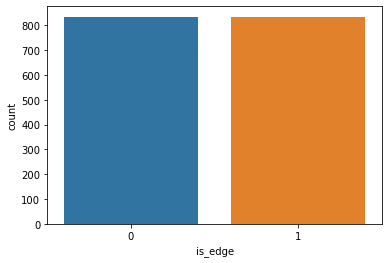

In [41]:
sns.countplot(x=df["is_edge"])

Analyzing the correlations between independent variables

In [21]:
corr = df.drop(columns='is_edge').corr()
corr.style.background_gradient(cmap='coolwarm')

,JC_score,PA_score,RA_score,RP_score,KATZ_score
JC_score,1.000000,0.022790,0.059379,-0.254811,-0.457741
PA_score,0.022790,1.000000,0.870768,0.429067,0.149131
RA_score,0.059379,0.870768,1.000000,0.514511,0.104169
RP_score,-0.254811,0.429067,0.514511,1.000000,0.716774
KATZ_score,-0.457741,0.149131,0.104169,0.716774,1.000000


In [22]:
df.describe()

,JC_score,PA_score,RA_score,RP_score,KATZ_score,is_edge
count,1670.000000,1670.000000,1670.000000,1.670000e+03,1.670000e+03,1670.00000
mean,0.169080,357.709581,0.244158,5.678301e-02,2.021695e-03,0.50000
std,0.352721,4382.283919,8.836660,8.337640e-02,2.021515e-03,0.50015
min,0.000000,1.000000,0.000000,1.700195e-07,7.896273e-10,0.00000
25%,0.000000,1.000000,0.000000,6.188857e-07,1.372989e-07,0.00000
50%,0.000000,26.000000,0.000000,1.720896e-03,2.017177e-03,0.50000
75%,0.006369,392.000000,0.002551,1.305869e-01,4.027286e-03,1.00000
max,1.000000,153664.000000,360.545845,1.736928e+00,1.035412e-02,1.00000


Standardizing features with StandardScaler() which removes the mean and scales to variance.

In [23]:
df.to_csv('protein_values.csv')

In [24]:
feature_names = ['JC_score', 'PA_score', 'RA_score']
X = df[feature_names]
y = df['is_edge'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Separating data for training and testing

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Testing different classification algorithms

### Logistic Regression - with GridSearchCV()

In [26]:
param_grid_logreg = [{'penalty':['l1', 'l2', 'elasticnet', 'none'], 
                   'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid_logreg, cv = 5)
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}])

In [27]:
print("Best parameters) ",logreg_cv.best_params_)
logreg_score = logreg_cv.score(X_test, y_test)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg_cv.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg_score))

Best parameters)  {'penalty': 'none', 'solver': 'newton-cg'}
Accuracy of Logistic regression classifier on training set: 0.97
Accuracy of Logistic regression classifier on test set: 0.97


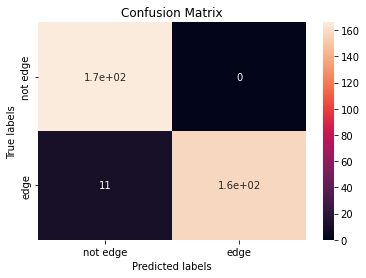

In [28]:
yhat_lr=logreg_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat_lr)

### Decision Tree Classifier - with GridSearchCV()

In [29]:
param_grid_dt = [{'criterion':['gini', 'entropy', 'log_loss'], 
                  'splitter':['best', 'random'],
                  'max_features':['auto', 'sqrt', 'log2']}]
dt = DecisionTreeClassifier()
dt_cv = GridSearchCV(dt, param_grid_dt, cv = 5)
dt_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['auto', 'sqrt', 'log2'],
                          'splitter': ['best', 'random']}])

In [30]:
print("Best parameters) ",dt_cv.best_params_)
dt_score = dt_cv.score(X_test, y_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dt_cv.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(dt_score))

Best parameters)  {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'random'}
Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 1.00


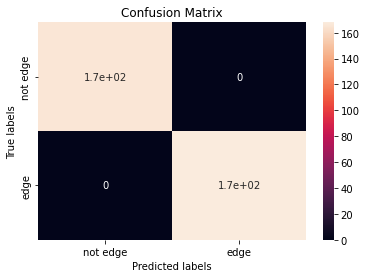

In [31]:
yhat_dt=dt_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat_dt)

### K-Nearest Neighbors - with GridSearchCV()

In [32]:
param_grid_knn = [{'n_neighbors':[5,7,9,11,15],
                   'algorithm':['auto','brute']}]
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid_knn, cv = 5)
knn_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'algorithm': ['auto', 'brute'],
                          'n_neighbors': [5, 7, 9, 11, 15]}])

In [33]:
print("Best parameters) ",knn_cv.best_params_)
knn_score = knn_cv.score(X_test, y_test)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn_cv.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn_score))

Best parameters)  {'algorithm': 'auto', 'n_neighbors': 7}
Accuracy of K-NN classifier on training set: 0.99
Accuracy of K-NN classifier on test set: 1.00


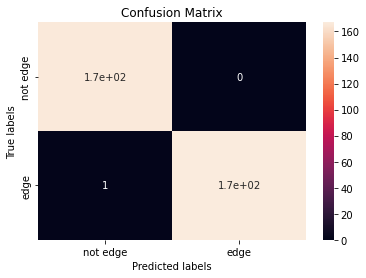

In [34]:
yhat_knn=knn_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat_knn)

### Support Vector Machine

In [37]:
svm = SVC()
svm.fit(X_train, y_train)

SVC()

In [38]:
svm_score = svm.score(X_test, y_test)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm_score))

Accuracy of SVM classifier on training set: 0.70
Accuracy of SVM classifier on test set: 0.70


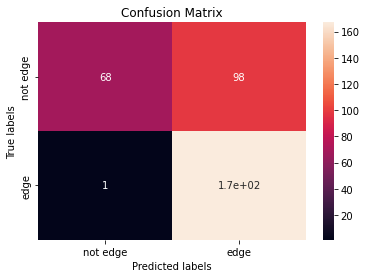

In [39]:
yhat_svc=svm.predict(X_test)
plot_confusion_matrix(y_test,yhat_svc)

### Artificial Neural Networks - Multilayer Perceptron - with GridSearchCV()

In [40]:
param_grid_ann = [{'activation':['identity','logistic', 'tanh', 'relu'], 
                   'solver':['lbfgs', 'sgd', 'adam']}]
ann = MLPClassifier()
ann_cv = GridSearchCV(ann, param_grid_ann, cv = 5)
ann_cv.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid=[{'activation': ['identity', 'logistic', 'tanh',
                                         'relu'],
                          'solver': ['lbfgs', 'sgd', 'adam']}])

In [41]:
print("Best Parameters ",ann_cv.best_params_)
ann_score = ann_cv.score(X_test, y_test)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(ann_cv.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(ann_score))

Melhores parâmetros :(best parameters)  {'activation': 'tanh', 'solver': 'lbfgs'}
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 1.00


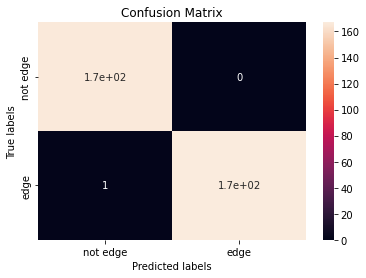

In [42]:
yhat_ann=ann_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat_ann)

#### Plotting accuracy scores

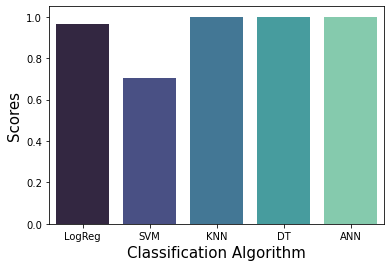

In [44]:
scores = {'LogReg':logreg_score, 'SVM':svm_score,'KNN':knn_score,
           'DT':dt_score, 'ANN':ann_score}

keys = list(scores.keys())
values = list(scores.values())
sns.barplot(x=keys, y=values, palette="mako")

plt.xlabel('Classification Algorithm', fontsize = 15)
plt.ylabel('Scores', fontsize = 15)
plt.show()

Calculating F1 Score of all tested models to compare

In [51]:
f1_logreg = f1_score(y_test, yhat_lr)
f1_svm = f1_score(y_test, yhat_svc)
f1_knn = f1_score(y_test, yhat_knn)
f1_dt = f1_score(y_test, yhat_dt)
f1_ann = f1_score(y_test, yhat_ann)

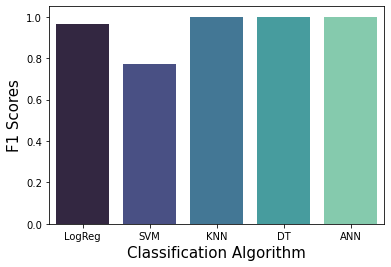

In [52]:
scores_f1 = {'LogReg':f1_logreg, 'SVM':f1_svm,'KNN':f1_knn,
           'DT':f1_dt, 'ANN':f1_ann}

keys_f1 = list(scores_f1.keys())
values_f1 = list(scores_f1.values())
sns.barplot(x=keys_f1, y=values_f1, palette="mako")

plt.xlabel('Classification Algorithm', fontsize = 15)
plt.ylabel('F1 Scores', fontsize = 15)
plt.show()

# Conclusion

The models performance ranking were Decision Tree, K-Nearest Neighbors, Artificial Neural Network, Logistic Regression and Support Vector Machines respectively.